In [1]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import io
import os
import re
import string
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (
  Embedding,Input,LSTM,Input,Conv2D,Softmax,Dropout,Dense,GRU,
  MaxPooling2D,LayerNormalization,Reshape,BatchNormalization,Bidirectional)
from tensorflow.keras.optimizers import Adam

In [2]:
print('Tensorflow => ',tf.__version__)
print('Keras      => ',tf.keras.__version__)
print('Numpy      => ',np.__version__)

Tensorflow =>  2.10.0
Keras      =>  2.10.0
Numpy      =>  1.25.2


In [3]:
gpus = tf.config.list_physical_devices('GPU')
gpus[0]
tf.config.experimental.set_memory_growth(gpus[0], True)

In [4]:
#####################################################################
# RUN THIS CODE CELL IF YOU ARE RESUMING THE NOTEBOOK AFTER A BREAK #
#####################################################################

# allocate 50% of GPU memory (if you like, feel free to change this)
#import requests
from keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.compat.v1.Session(config=config))

# watch for any changes in the sample_models module, and reload it automatically
%load_ext autoreload
%autoreload 2

In [5]:
BATCH_SIZE=8
LR=1e-4
FRAME_LENGTH=255
FRAME_STEP=128
N_EPOCHS=100

# Tamil Female

## Data Visualization

In [6]:
audio_binary=tf.io.read_file("D:/CDAC/Datasets/IndicTTS/IndicTTS_Phase2_Tamil_fem_Speaker1_english/english/wav/train_tamilfemale_00001.wav")
audio,_=tf.audio.decode_wav(audio_binary)
waveform=tf.squeeze(audio,axis=-1)
waveform=tf.cast(waveform,tf.float32)
signal=waveform
print(signal.shape)

(179520,)


(179520,)


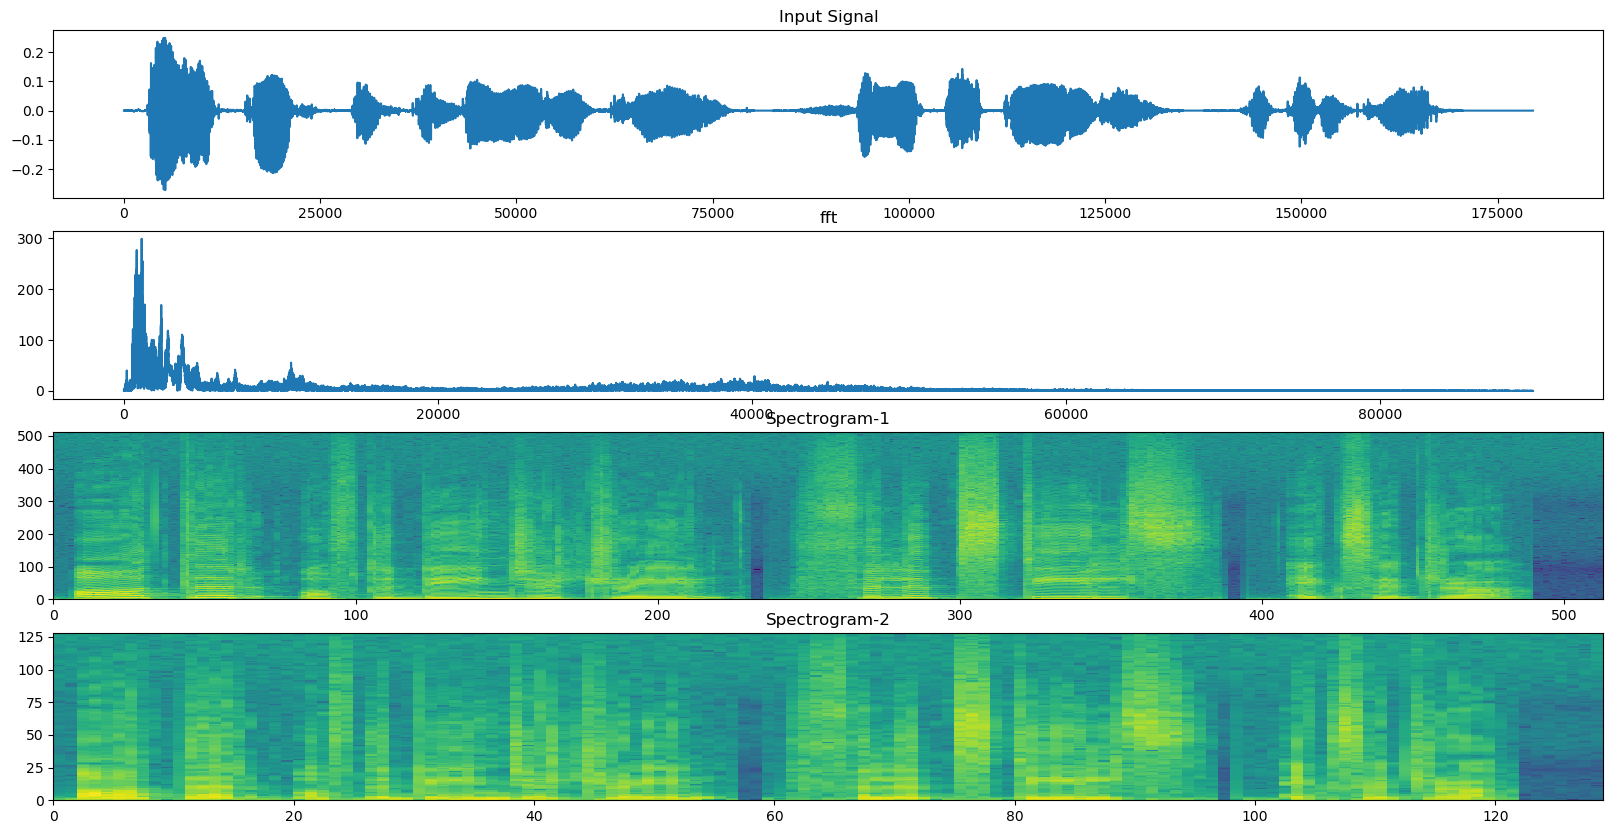

In [7]:
fig,axis=plt.subplots(4,figsize=(20,10))

L=2000
x=tf.linspace(-L//2,L//2,L)
print(signal.shape)
axis[0].plot(signal)
axis[0].set_title("Input Signal")

fft=tf.signal.rfft(signal)

axis[1].plot(tf.abs(fft))
axis[1].set_title("fft")


spec=tf.signal.stft(signal,frame_length=1024,frame_step=512,)
spec=tf.transpose(tf.abs(spec),[1,0])

power_spec=np.log(spec)
height=power_spec.shape[0]

width=power_spec.shape[1]

X=np.linspace(0,power_spec.shape[0],num=width,dtype=int)
Y=range(height)

axis[2].pcolormesh(X,Y,power_spec)
axis[2].set_title("Spectrogram-1")


spec=tf.signal.stft(signal,frame_length=256,frame_step=128, )
spec=tf.transpose(tf.abs(spec),[1,0])

power_spec=np.log(spec)
height=power_spec.shape[0]

width=power_spec.shape[1]

X=np.linspace(0,power_spec.shape[0],num=width,dtype=int)
Y=range(height)

axis[3].pcolormesh(X,Y,power_spec)
axis[3].set_title("Spectrogram-2")


plt.show()


## Data Preparation

In [8]:
audio_text2={}
csv_path="D:/CDAC/Datasets/IndicTTS/IndicTTS_Phase2_Tamil_fem_Speaker1_english/english/txt.done.data"
with open(csv_path, encoding="utf-8") as f:
  for line in f:
    i=line.strip().split(" \" ")[0].removeprefix("( ")    
    text=line.strip().split(" \" ")[1].removesuffix(' " )')    
    audio_text2[str(i)]=text    

audio_text2

{'train_tamilfemale_00001': 'Author of the danger trail, Philip Steels, etc.',
 'train_tamilfemale_00002': 'Not at this particular case, Tom, apologized Whittemore.',
 'train_tamilfemale_00003': 'For the twentieth time that evening the two men shook hands.',
 'train_tamilfemale_00004': "Lord, but I'm glad to see you again, Phil.",
 'train_tamilfemale_00005': 'Will we ever forget it.',
 'train_tamilfemale_00006': "God bless 'em, I hope I'll go on seeing them forever.",
 'train_tamilfemale_00007': 'And you always want to see it in the superlative degree.',
 'train_tamilfemale_00008': 'Gad, your letter came just in time.',
 'train_tamilfemale_00009': 'He turned sharply, and faced Gregson across the table.',
 'train_tamilfemale_00010': "I'm playing a single hand in what looks like a losing game.",
 'train_tamilfemale_00011': 'If I ever needed a fighter in my life I need one now.',
 'train_tamilfemale_00012': 'Gregson shoved back his chair and rose to his feet.',
 'train_tamilfemale_00013':

In [9]:
filepaths=["D:/CDAC/Datasets/IndicTTS/IndicTTS_Phase2_Tamil_fem_Speaker1_english/english/wav/"+filename+".wav" for filename in list(audio_text2.keys())]
transcriptions=[audio_text2[str(filename)].lower() for filename in list(audio_text2.keys())]
print(len(filepaths))
print(len(transcriptions))

7913
7913


In [10]:
dataset=tf.data.Dataset.from_tensor_slices((filepaths,transcriptions))

for i in dataset.take(1):
  print(i)

(<tf.Tensor: shape=(), dtype=string, numpy=b'D:/CDAC/Datasets/IndicTTS/IndicTTS_Phase2_Tamil_fem_Speaker1_english/english/wav/train_tamilfemale_00001.wav'>, <tf.Tensor: shape=(), dtype=string, numpy=b'author of the danger trail, philip steels, etc.'>)


In [11]:
def decode_audio(audio_binary):
    audio,_=tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio,axis=-1)

In [12]:
vocabulary=[""]+[chr(i) for i in range(97,97+26)]+[".",",","?"," "]
print(vocabulary)
print(len(vocabulary))

['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '.', ',', '?', ' ']
31


In [13]:
def get_label(label,):
    label=tf.strings.unicode_split(label, input_encoding="UTF-8")
    label=tf.keras.layers.StringLookup(vocabulary=vocabulary, oov_token="")(label)
    return label

In [14]:
def get_spec(filepath,label):

  audio_binary=tf.io.read_file(filepath)
  waveform=decode_audio(audio_binary)
  waveform=tf.cast(waveform,tf.float32)

  spectrogram=tf.signal.stft(
      waveform,frame_length=FRAME_LENGTH,frame_step=FRAME_STEP)
  spectrogram=tf.abs(spectrogram)
  label=get_label(label)
  return tf.expand_dims(spectrogram,axis=-1),label

In [15]:
processed_dataset = (
    dataset.map(get_spec, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [16]:
train_dataset=processed_dataset.take(int(0.95*len(processed_dataset)))
val_dataset=processed_dataset.skip(int(0.95*len(processed_dataset)))

In [17]:
for i,j in train_dataset.take(1):
  print(i,j)

tf.Tensor(
[[[[3.35961320e-02]
   [2.39276178e-02]
   [1.20047443e-02]
   ...
   [2.22093426e-03]
   [9.57494078e-04]
   [2.00709328e-03]]

  [[1.29544120e-02]
   [4.97288741e-02]
   [2.68298984e-02]
   ...
   [1.13211491e-03]
   [4.87971149e-04]
   [8.51661433e-04]]

  [[5.01942635e-02]
   [8.16674978e-02]
   [3.82123552e-02]
   ...
   [2.32737846e-04]
   [1.37336343e-03]
   [1.61901116e-05]]

  ...

  [[0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]
   ...
   [0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]]

  [[0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]
   ...
   [0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]]

  [[0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]
   ...
   [0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]]]


 [[[1.11507252e-05]
   [1.86897742e-05]
   [2.02132105e-05]
   ...
   [2.73243128e-03]
   [1.85950496e-03]
   [1.20080286e-03]]

  [[5.20289177e-06]
   [9.80519599e-06]
   [1.16152005e-05]
   ...
   [1.3663

## Modeling 

In [18]:
normalization=tf.keras.layers.Normalization()

In [19]:
input_spectrogram=Input((None,129,1), name="input")

x=normalization(input_spectrogram)
x=Conv2D(32,kernel_size=[11,41],strides=[2,2],padding='same',activation='relu')(x)
x=LayerNormalization()(x)
x=Conv2D(64,kernel_size=[11,21],strides=[1,2],padding='same',activation='relu')(x)
x=LayerNormalization()(x)

x=Reshape((-1, x.shape[-2] * x.shape[-1]))(x)

x=Bidirectional(GRU(128,return_sequences=True))(x)
x=Bidirectional(GRU(128,return_sequences=True))(x)
x=Bidirectional(GRU(128,return_sequences=True))(x)


output=Dense(len(vocabulary)+1, activation="softmax")(x)

model = tf.keras.Model(input_spectrogram, output, name="DeepSpeech_2_Inspired")
model.summary()

Model: "DeepSpeech_2_Inspired"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, None, 129, 1)]    0         
                                                                 
 normalization (Normalizatio  (None, None, 129, 1)     3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, None, 65, 32)      14464     
                                                                 
 layer_normalization (LayerN  (None, None, 65, 32)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, None, 33, 64)      473152    
                                                                 
 layer_normalization_1 (Laye  (None, None, 33

In [20]:
def ctc_loss(y_true,y_pred):
  batch_size=tf.shape(y_pred)[0]
  pred_length=tf.shape(y_pred)[1]
  true_length=tf.shape(y_true)[1]

  pred_length=pred_length*tf.ones([batch_size,1],dtype=tf.int32)
  true_length=true_length*tf.ones([batch_size,1],dtype=tf.int32)

  return tf.keras.backend.ctc_batch_cost(y_true,y_pred,pred_length,true_length)

In [21]:
model.compile(
    loss=ctc_loss,
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
)

In [22]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("ASR_IndicTTS_Tamil_Female_Model-{epoch:03d}.h5")
model_path='D:/CDAC/Project/ASR-using-deepspeech2/ASR_IndicTTS_Tamil_Female_Model_Final.h5'

## Training

In [23]:
history=model.fit(
  train_dataset,
  validation_data=val_dataset,
  verbose=1,
  epochs=N_EPOCHS,  
  callbacks=[checkpoint_cb]  
)

Epoch 1/100
940/940 [==============================] - 2485s 3s/step - loss: 315.5010 - val_loss: 345.8546
Epoch 2/100
940/940 [==============================] - 916s 975ms/step - loss: 228.8837 - val_loss: 272.7672
Epoch 3/100
940/940 [==============================] - 907s 966ms/step - loss: 179.0950 - val_loss: 186.6557
Epoch 4/100
940/940 [==============================] - 915s 974ms/step - loss: 113.5695 - val_loss: 141.6803
Epoch 5/100
940/940 [==============================] - 925s 985ms/step - loss: 86.2693 - val_loss: 129.0815
Epoch 6/100
940/940 [==============================] - 928s 988ms/step - loss: 74.0169 - val_loss: 114.7044
Epoch 7/100
940/940 [==============================] - 960s 1s/step - loss: 66.0472 - val_loss: 107.8404
Epoch 8/100
940/940 [==============================] - 957s 1s/step - loss: 60.0848 - val_loss: 103.7186
Epoch 9/100
940/940 [==============================] - 920s 979ms/step - loss: 55.2007 - val_loss: 98.6214
Epoch 10/100
940/940 [===========

In [24]:
# save model
model.save(model_path)

## Testing

In [23]:
#obtain and decode the acoustic model's predictions
model.load_weights(model_path)

In [24]:
def get_spec_inference(filepath):

  audio_binary=tf.io.read_file(filepath)
  waveform=decode_audio(audio_binary)
  waveform=tf.cast(waveform,tf.float32)

  spectrogram=tf.signal.stft(
      waveform,frame_length=FRAME_LENGTH,frame_step=FRAME_STEP)

  spectrogram=tf.abs(spectrogram)

  return tf.expand_dims(spectrogram,axis=-1)

In [25]:
def decode(y_pred):
  batch_size=tf.shape(y_pred)[0]
  print(tf.shape(y_pred))

  pred_length=tf.shape(y_pred)[1]
  pred_length*=tf.ones([batch_size,],dtype=tf.int32)

  y_pred=tf.one_hot(y_pred,len(vocabulary)+1)
  output=tf.keras.backend.ctc_decode(y_pred,input_length=pred_length,greedy=True)[0][0]

  out=[vocabulary[i] for i in output[0]]
  return ''.join(out)

In [1]:
test_path="D:/CDAC/Datasets/IndicTTS/IndicTTS_Phase2_Tamil_fem_Speaker1_english/english/wav/train_tamilfemale_05000.wav"
from IPython.display import Audio
# play the audio file
Audio(test_path)

In [40]:
spectrogram=get_spec_inference(test_path)
print(spectrogram.shape)
out=tf.argmax(model.predict(tf.expand_dims(spectrogram,axis=0))[0],axis=1)
out

(2773, 129, 1)
1/1 [==============================] - 1s 515ms/step


<tf.Tensor: shape=(1387,), dtype=int64, numpy=array([31, 31, 31, ...,  0,  0,  0], dtype=int64)>

In [41]:
out_list=[vocabulary[i] if i!=31 else "[LINK]" for i in out]
out_str="".join(out_list)
print(out_str)

[LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK]rrrrr[LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK

In [42]:
transcription=decode(tf.expand_dims(out,axis=0))
print(transcription)

tf.Tensor([   1 1387], shape=(2,), dtype=int32)
ramuns cat was lee and hungry and all other cats where stounk and happy                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [44]:
# !pip install pyspellchecker
from spellchecker import SpellChecker

spelling = SpellChecker()
def spelling_checks(text):
  correct_result = []
  typo_words = spelling.unknown(text.split())
  for word in text.split():
    if word in typo_words:
      correct_result.append(spelling.correction(word))
    else:
      correct_result.append(word)
  return " ".join(correct_result)

corrected_transcription=spelling_checks(transcription)
print(corrected_transcription)

runs cat was lee and hungry and all other cats where stunk and happy


In [1]:
%pip  list

Package                      Version
---------------------------- ------------
absl-py                      2.1.0
asttokens                    2.4.1
astunparse                   1.6.3
audioread                    3.0.1
Bottleneck                   1.3.7
cachetools                   5.3.3
certifi                      2024.6.2
cffi                         1.16.0
charset-normalizer           3.3.2
click                        8.1.7
colorama                     0.4.6
comm                         0.2.2
contourpy                    1.2.0
cycler                       0.11.0
debugpy                      1.8.1
decorator                    5.1.1
exceptiongroup               1.2.0
executing                    2.0.1
ffmpeg                       1.4
filelock                     3.15.4
flatbuffers                  2.0.7
fonttools                    4.51.0
fsspec                       2024.6.1
gast                         0.4.0
google-auth                  2.30.0
google-auth-oauthlib         0.4.6
go

In [2]:
%pip install speechrecognition

   ---------------------------------------- 0.0/32.8 MB ? eta -:--:--
   --- ------------------------------------ 3.0/32.8 MB 96.5 MB/s eta 0:00:01
   ------ --------------------------------- 5.4/32.8 MB 68.7 MB/s eta 0:00:01
   -------- ------------------------------- 7.1/32.8 MB 56.4 MB/s eta 0:00:01
   ----------- ---------------------------- 9.8/32.8 MB 57.1 MB/s eta 0:00:01
   -------------- ------------------------- 12.0/32.8 MB 50.4 MB/s eta 0:00:01
   ----------------- ---------------------- 14.3/32.8 MB 50.1 MB/s eta 0:00:01
   -------------------- ------------------- 16.5/32.8 MB 50.4 MB/s eta 0:00:01
   ---------------------- ----------------- 18.5/32.8 MB 46.9 MB/s eta 0:00:01
   ----------------------- ---------------- 19.4/32.8 MB 40.9 MB/s eta 0:00:01
   ------------------------ --------------- 20.2/32.8 MB 36.4 MB/s eta 0:00:01
   ----------------------------- ---------- 24.2/32.8 MB 46.9 MB/s eta 0:00:01
   ------------------------------- -------- 25.5/32.8 MB 38.5 MB/


[notice] A new release of pip is available: 24.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import speech_recognition as sr
r = sr.Recognizer()


In [3]:
def speech_to_text(audio_file):
  """
  Opens and listens to an audio file and translates it to text
  Args: audio file
  Returns: text of transcribed audio file
  """
  with sr.AudioFile(audio_file) as source:
    audio_text = r.listen(source)
    try:
        text = r.recognize_google(audio_text)
        print('Converting audio transcripts into text ...')
        # print(text)
    except:
         print('Sorry.. run again...')

    return text

In [6]:
speech_to_text(test_path)


Converting audio transcripts into text ...


"Raman's cat was lean and hungry and all other cats wished out and happy"